<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">




In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import train_test_split
from music21 import *
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from tensorflow.keras.optimizers import Adam

## EDA on individual jazz compositions

In [4]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [5]:
path='/content/'


#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/alb_se1.mid
Loading Music File: /content/grieg_voeglein.mid
Loading Music File: /content/haydn_9_1.mid
Loading Music File: /content/grieg_wanderer.mid
Loading Music File: /content/chpn-p10.mid
Loading Music File: /content/mendel_op30_2.mid
Loading Music File: /content/deb_prel.mid
Loading Music File: /content/chpn-p11.mid
Loading Music File: /content/liz_et_trans8.mid
Loading Music File: /content/alb_se6.mid
Loading Music File: /content/br_rhap.mid
Loading Music File: /content/burg_spinnerlied.mid
Loading Music File: /content/appass_3.mid
Loading Music File: /content/grieg_walzer.mid
Loading Music File: /content/gra_esp_3.mid
Loading Music File: /content/deb_menu.mid
Loading Music File: /content/scn15_5.mid
Loading Music File: /content/schumm-4.mid
Loading Music File: /content/schubert_D850_2.mid
Loading Music File: /content/burg_perlen.mid
Loading Music File: /content/scn15_10.mid
Loading Music File: /content/mendel_op19_3.mid
Loading Music File: /content/

In [6]:
#flatten array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

477


In [7]:
print(len(notes_))

472561


In [8]:
print("First fifty notes:",notes_[:50])

First fifty notes: ['0.5', '0.5', '9.0', '5.9', '5.9.0', '5.9.0', '0.5', '9.0', 'E4', '5.9.0', 'D4', 'C4', '5.9.0', 'D4', 'E4', '0.5', '9.0', 'F3', 'D4', 'E4', 'D4', '5.9.0', 'C4', '5.9.0', '0.5', '9.0', '5.9.0', '5.9.0', '0.5', '0.5', '9.0', '5.9', '5.9.0', '5.9.0', '0.5', '9.0', 'E4', '5.9.0', 'D4', 'C4', '5.9.0', 'D4', 'E4', '0.5', '9.0', 'D4', 'F3', 'E4', 'D4', '5.9.0']


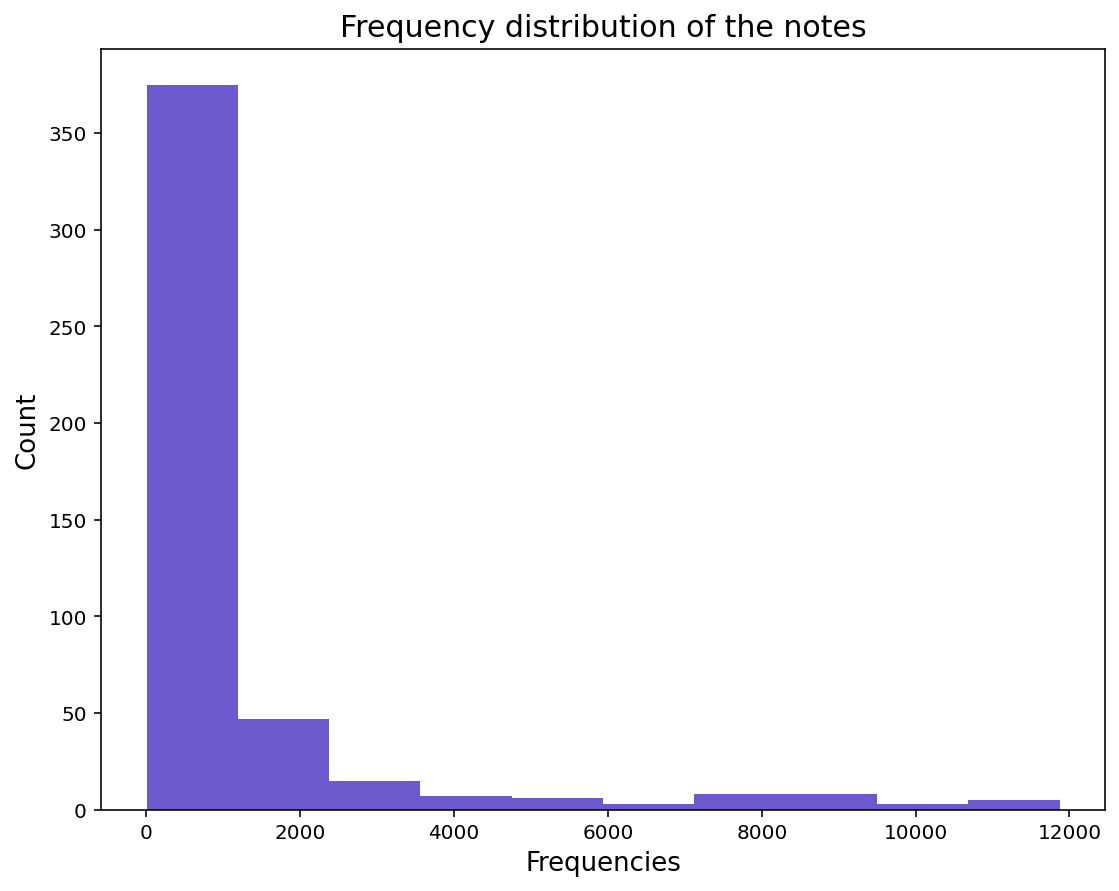

In [9]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(9,7))

#plot
plt.title("Frequency distribution of the notes", fontsize=15)
plt.ylabel('Count', fontsize= 13)
plt.xlabel('Frequencies', fontsize= 13)
plt.hist(no, color = 'slateblue');

In [10]:
frequent_notes = [note_ for note_, count in freq.items() if count>=40]
#for this modeling frequent notes has been redefined to >40.  
#We had it initially defined as >50 in the first version of the model
print(len(frequent_notes))

251


In [11]:
#files will only contain frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [12]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [13]:
#Each note gets a unique integer
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [14]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [15]:
#preparing integer sequences for output data.
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [16]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

## Make it compatible with lstm by normalizing input and one hot encodint the output

In [17]:
n_vocab = len(set(notes))

In [18]:
len_unique=len(unique_notes)
len_unique

477

In [20]:
len(y)

461961

In [21]:
x_seq

array([[214, 214,  95, ..., 214,  95, 186],
       [214,  95, 186, ...,  95, 186,  66],
       [ 95, 186,  66, ..., 186,  66,  66],
       ...,
       [133, 114, 133, ..., 114, 133, 133],
       [114, 133,  44, ..., 133, 133, 133],
       [133,  44, 133, ..., 133, 133, 231]])

In [22]:
x_patterns=len(x)
x_input=(np.reshape(x_seq,(len(y),no_of_timesteps,1)))/len_unique
#https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [23]:
y=tf.keras.utils.to_categorical(y_seq)
#https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/

## LSTM Model

In [24]:
model = Sequential()
model.add(LSTM(128, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 251)               64507     
                                                                 
Total params: 197,115
Trainable params: 197,115
Non-trainable params: 0
_________________________________________________________________


In [25]:
mc6=ModelCheckpoint('best_model_6.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [26]:
history6 = model.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=65, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc6])


Epoch 1/65
5772/5775 [============================>.] - ETA: 0s - loss: 4.4568
Epoch 00001: val_loss improved from inf to 4.26410, saving model to best_model_6.h5
5775/5775 [==============================] - 53s 8ms/step - loss: 4.4567 - val_loss: 4.2641
Epoch 2/65
5769/5775 [============================>.] - ETA: 0s - loss: 4.1703
Epoch 00002: val_loss improved from 4.26410 to 4.09209, saving model to best_model_6.h5
5775/5775 [==============================] - 46s 8ms/step - loss: 4.1701 - val_loss: 4.0921
Epoch 3/65
5772/5775 [============================>.] - ETA: 0s - loss: 4.0041
Epoch 00003: val_loss improved from 4.09209 to 3.98718, saving model to best_model_6.h5
5775/5775 [==============================] - 46s 8ms/step - loss: 4.0040 - val_loss: 3.9872
Epoch 4/65
5774/5775 [============================>.] - ETA: 0s - loss: 3.8930
Epoch 00004: val_loss improved from 3.98718 to 3.92060, saving model to best_model_6.h5
5775/5775 [==============================] - 46s 8ms/step - 

In [27]:
from keras.models import load_model
model =load_model('best_model_6.h5')

In [29]:
import random
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions = []

for i in range(50):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions)

[203, 203, 208, 208, 208, 208, 208, 208, 208, 208, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 208, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191, 247, 191]


In [30]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))

predicted_notes = [x_int_to_note[i] for i in predictions]

In [31]:
# convert preds to midi files
def convert_to_midi(prediction_output):

  offset = 0
  output_notes = []

  for pattern in prediction_output:

    if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
    else:    
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
    offset += 1
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp='music.mid')

In [32]:
convert_to_midi(predicted_notes)

In [33]:
predicted_notes

['10.3',
 '10.3',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'C#7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7',
 'E7',
 'E-7']

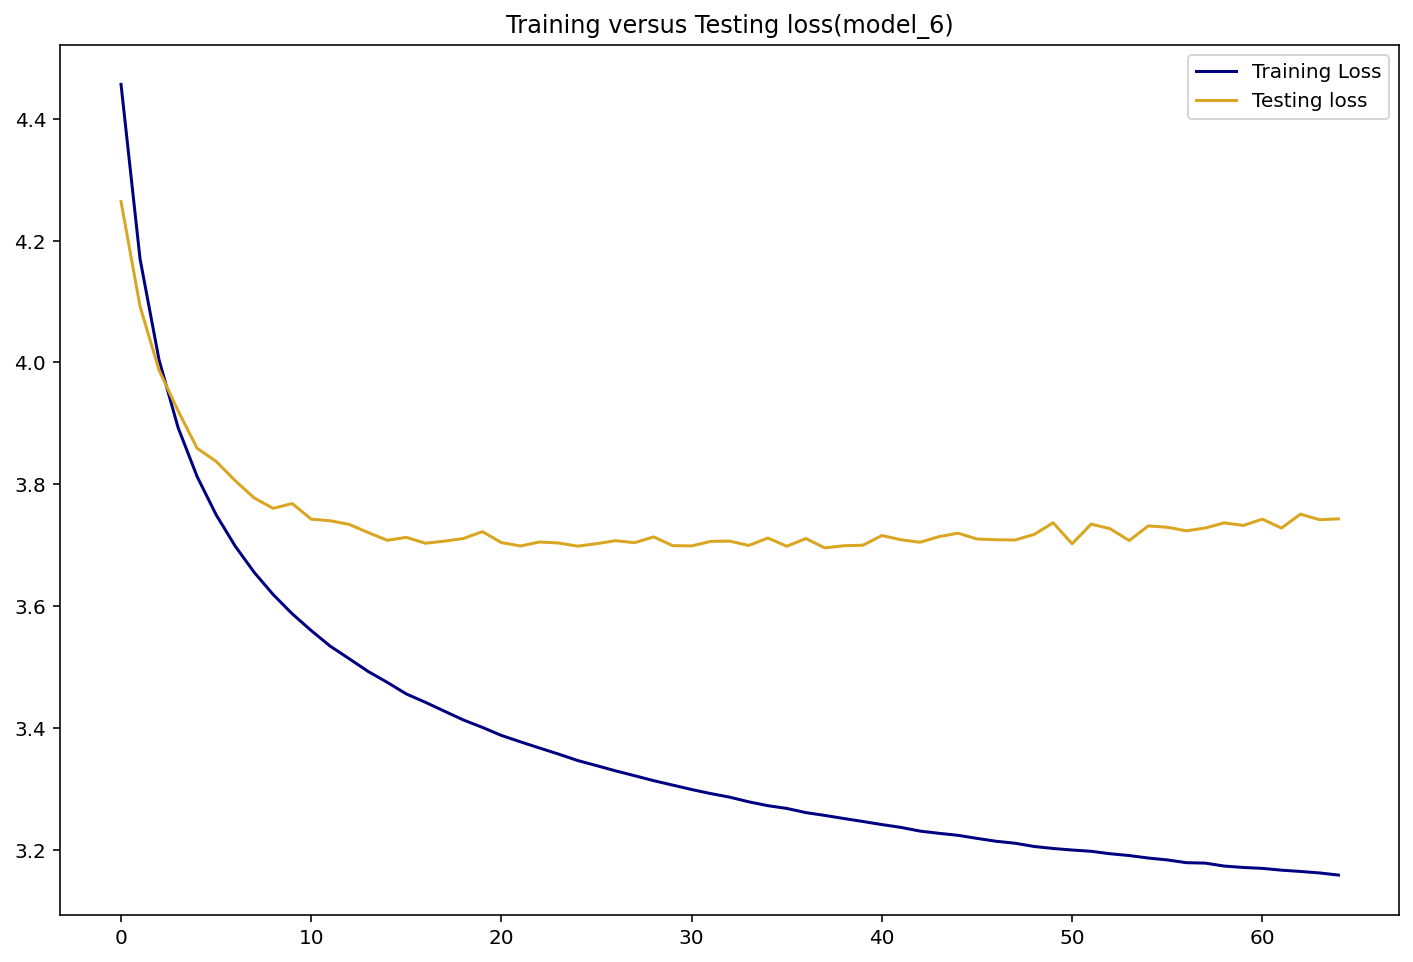

In [34]:
train_loss6=history6.history['loss']
test_loss6= history6.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_6)')
plt.plot(train_loss6, label ='Training Loss', color = 'navy')
plt.plot(test_loss6, label = 'Testing loss', color = 'goldenrod')
plt.legend();
plt.savefig('lstm_model_loss_plot(6).png')

Extremely underfit model, and the val_loss is the worst of all models at 3.73552.

In [35]:
model7 = Sequential()
model7.add(LSTM(256, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model7.add(LSTM(128, return_sequences = False))
model7.add(Dense(256, activation='relu'))
model7.add(Dense(256, activation='relu'))
model7.add(Dense(len(unique_y), activation = 'softmax'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam')

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32, 256)           264192    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 251)               64507     
                                                                 
Total params: 624,635
Trainable params: 624,635
Non-trainable params: 0
_________________________________________________________________


In [36]:
mc7=ModelCheckpoint('best_model_7.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [37]:
history7=model7.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=60, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc7])


Epoch 1/60
5774/5775 [============================>.] - ETA: 0s - loss: 4.4811
Epoch 00001: val_loss improved from inf to 4.28573, saving model to best_model_7.h5
5775/5775 [==============================] - 52s 9ms/step - loss: 4.4810 - val_loss: 4.2857
Epoch 2/60
5770/5775 [============================>.] - ETA: 0s - loss: 4.1470
Epoch 00002: val_loss improved from 4.28573 to 4.08156, saving model to best_model_7.h5
5775/5775 [==============================] - 49s 8ms/step - loss: 4.1469 - val_loss: 4.0816
Epoch 3/60
5772/5775 [============================>.] - ETA: 0s - loss: 3.9629
Epoch 00003: val_loss improved from 4.08156 to 3.93797, saving model to best_model_7.h5
5775/5775 [==============================] - 48s 8ms/step - loss: 3.9629 - val_loss: 3.9380
Epoch 4/60
5775/5775 [==============================] - ETA: 0s - loss: 3.8306
Epoch 00004: val_loss improved from 3.93797 to 3.86490, saving model to best_model_7.h5
5775/5775 [==============================] - 49s 8ms/step - 

In [38]:

model =load_model('best_model_7.h5')

In [39]:
import random
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions7 = []

for i in range(50):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions7.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions7)

[53, 77, 103, 53, 177, 249, 53, 180, 103, 103, 103, 180, 180, 69, 103, 180, 8, 35, 180, 87, 180, 180, 8, 35, 53, 8, 53, 173, 69, 8, 53, 173, 103, 23, 53, 202, 103, 23, 53, 202, 133, 69, 23, 173, 53, 113, 177, 103, 23, 177]


In [41]:
predicted_notes7 = [x_int_to_note[i] for i in predictions7]

In [42]:
convert_to_midi(predicted_notes7)
predicted_notes7

['E4',
 'E2',
 'A3',
 'E4',
 'E3',
 'B3',
 'E4',
 'E5',
 'A3',
 'A3',
 'A3',
 'E5',
 'E5',
 'A4',
 'A3',
 'E5',
 'C#5',
 'D5',
 'E5',
 'F#5',
 'E5',
 'E5',
 'C#5',
 'D5',
 'E4',
 'C#5',
 'E4',
 'B4',
 'A4',
 'C#5',
 'E4',
 'B4',
 'A3',
 'E-4',
 'E4',
 '4.8.11',
 'A3',
 'E-4',
 'E4',
 '4.8.11',
 'G#3',
 'A4',
 'E-4',
 'B4',
 'E4',
 'G#4',
 'E3',
 'A3',
 'E-4',
 'E3']

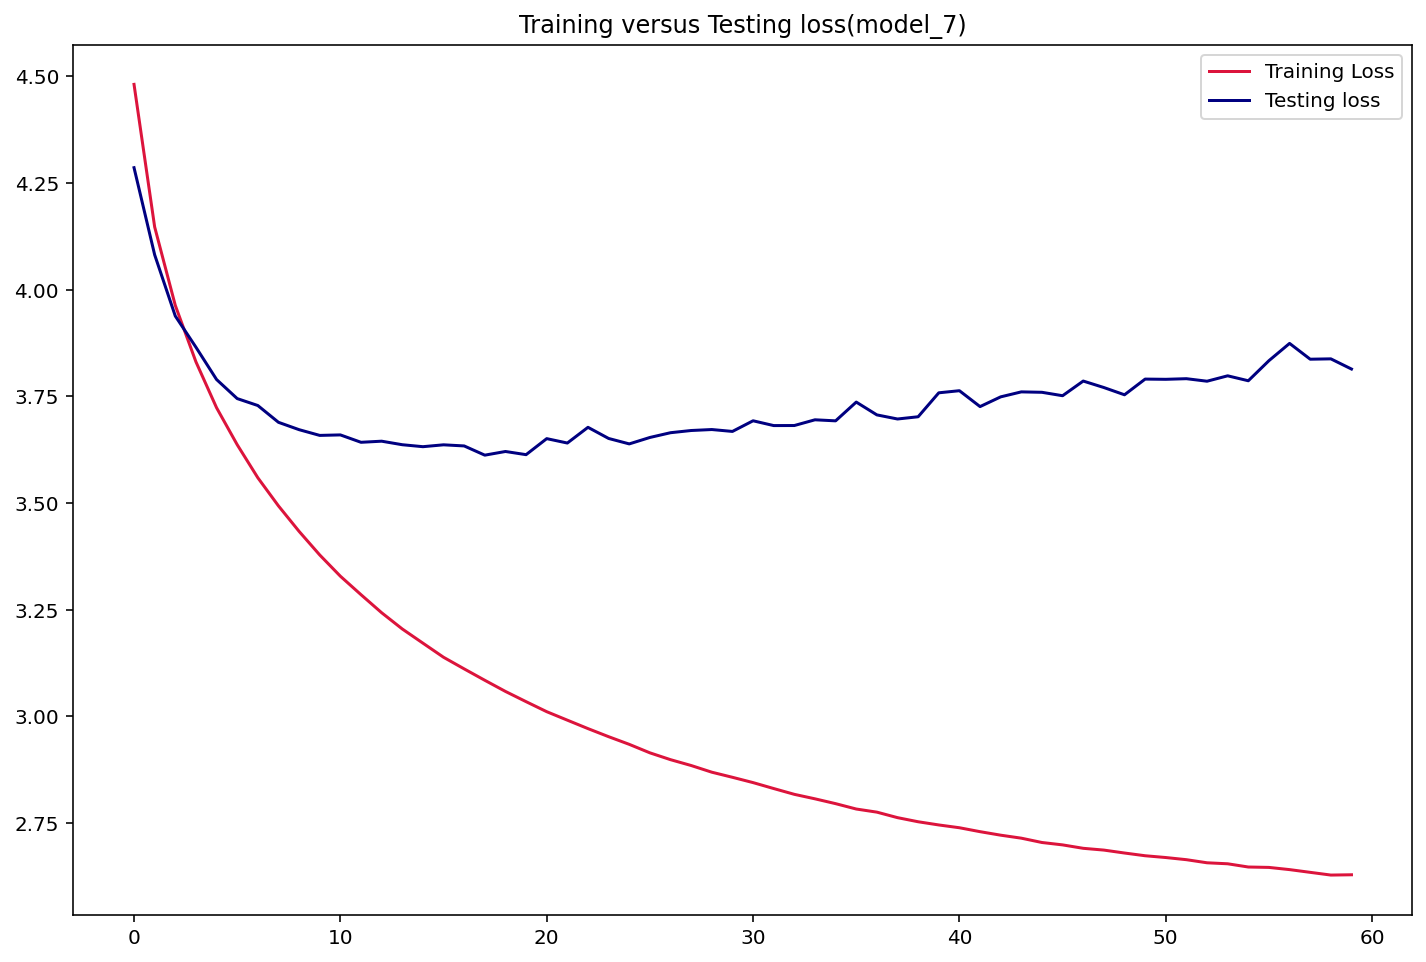

In [43]:
train_loss7=history7.history['loss']
test_loss7= history7.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_7)')
plt.plot(train_loss7, label ='Training Loss', color = 'crimson')
plt.plot(test_loss7, label = 'Testing loss', color = 'navy')
plt.legend();
plt.savefig('lstm_7thmodel_loss_plot.png')

In [45]:
model8 = Sequential()
model8.add(LSTM(512, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model8.add(LSTM(256, return_sequences = False))
model8.add(Dense(512, activation='relu'))
model8.add(Dense(256, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(len(unique_y), activation = 'softmax'))
model8.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=.0009))
model8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32, 512)           1052672   
                                                                 
 lstm_7 (LSTM)               (None, 256)               787456    
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 251)               32379     
                                                                 
Total params: 2,168,315
Trainable params: 2,168,315
No

In [46]:
mc8=ModelCheckpoint('best_model_8.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history8=model8.fit(np.array(x_tr), np.array(y_tr), batch_size=32, 
                    epochs=40, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc8])

Epoch 1/40
11544/11549 [============================>.] - ETA: 0s - loss: 4.5292
Epoch 00001: val_loss improved from inf to 4.37897, saving model to best_model_8.h5
11549/11549 [==============================] - 93s 8ms/step - loss: 4.5291 - val_loss: 4.3790
Epoch 2/40
11548/11549 [============================>.] - ETA: 0s - loss: 4.2723
Epoch 00002: val_loss improved from 4.37897 to 4.18332, saving model to best_model_8.h5
11549/11549 [==============================] - 90s 8ms/step - loss: 4.2723 - val_loss: 4.1833
Epoch 3/40
11547/11549 [============================>.] - ETA: 0s - loss: 4.0889
Epoch 00003: val_loss improved from 4.18332 to 4.08539, saving model to best_model_8.h5
11549/11549 [==============================] - 90s 8ms/step - loss: 4.0889 - val_loss: 4.0854
Epoch 4/40
11542/11549 [============================>.] - ETA: 0s - loss: 3.9696
Epoch 00004: val_loss improved from 4.08539 to 3.96570, saving model to best_model_8.h5
11549/11549 [==============================] -

In [47]:
model8= load_model('best_model_8.h5')

In [49]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions8 = []

for i in range(45):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model8.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions8.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions8)

[74, 103, 80, 80, 0, 49, 75, 0, 49, 97, 74, 0, 86, 80, 23, 86, 86, 0, 74, 80, 74, 0, 74, 80, 80, 248, 80, 0, 44, 103, 74, 0, 86, 80, 31, 75, 31, 0, 86, 0, 248, 80, 0, 248, 75]


In [50]:
predicted_notes8 = [x_int_to_note[i] for i in predictions8]
convert_to_midi(predicted_notes8)
predicted_notes8

['D4',
 'A3',
 'F3',
 'F3',
 'D3',
 'B-3',
 'E-3',
 'D3',
 'B-3',
 'B-2',
 'D4',
 'D3',
 'F4',
 'F3',
 'E-4',
 'F4',
 'F4',
 'D3',
 'D4',
 'F3',
 'D4',
 'D3',
 'D4',
 'F3',
 'F3',
 'B-4',
 'F3',
 'D3',
 'C4',
 'A3',
 'D4',
 'D3',
 'F4',
 'F3',
 'G4',
 'E-3',
 'G4',
 'D3',
 'F4',
 'D3',
 'B-4',
 'F3',
 'D3',
 'B-4',
 'E-3']

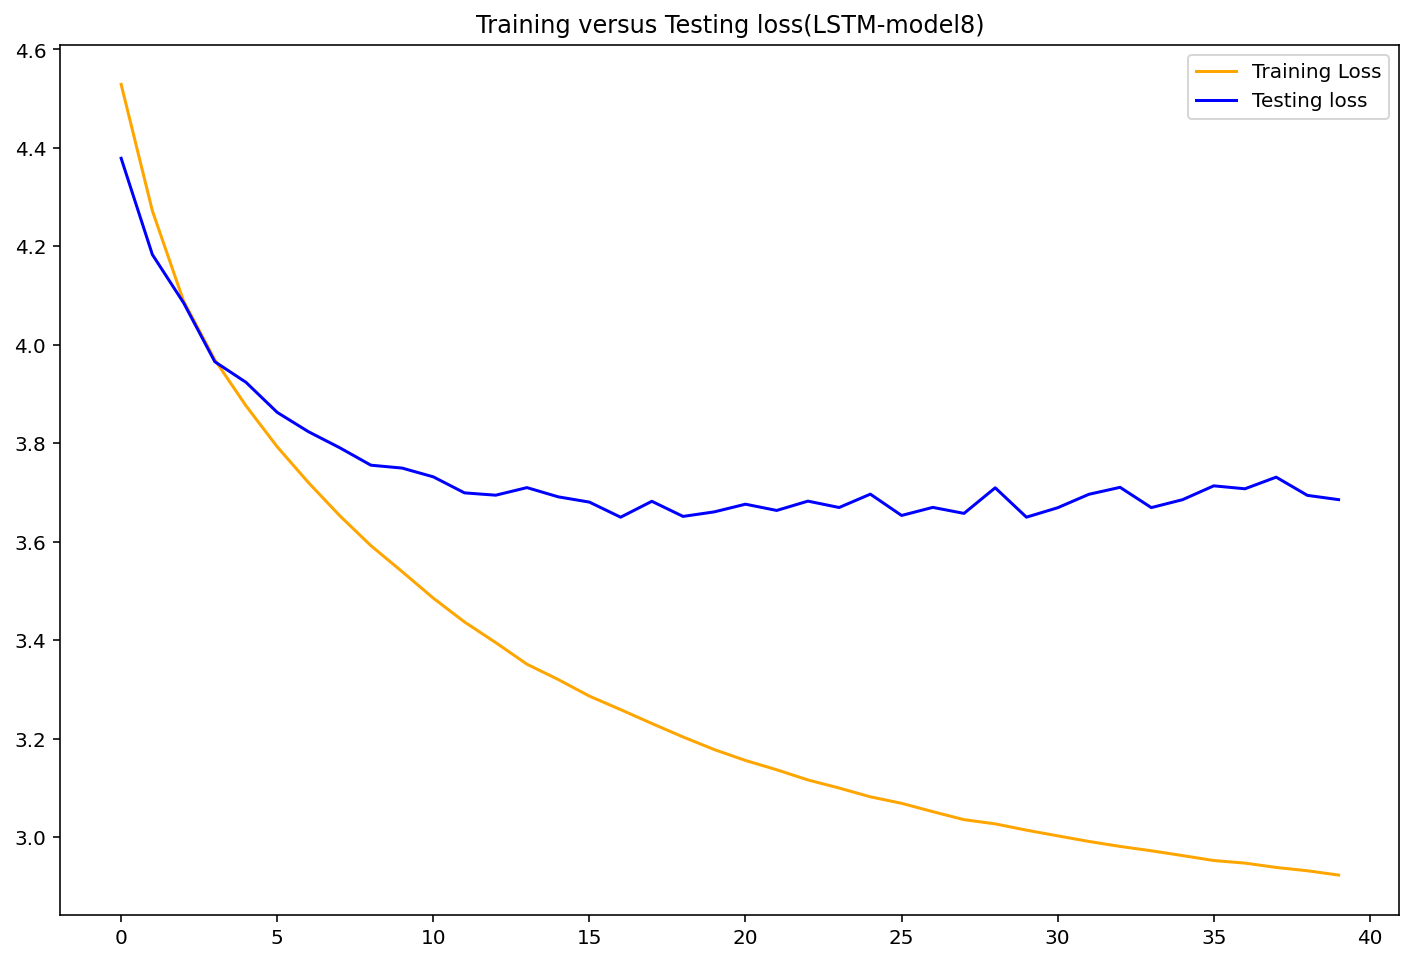

In [51]:
train_loss8=history8.history['loss']
test_loss8= history8.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(LSTM-model8)')
plt.plot(train_loss8, label ='Training Loss', color = 'orange')
plt.plot(test_loss8, label = 'Testing loss', color = 'blue')
plt.legend();
plt.savefig('8thmodel_loss_plot.png')

In [52]:
model9 = Sequential()
model9.add(LSTM(512, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model9.add(Dropout(0.25))
model9.add(LSTM(256, return_sequences = False))
model9.add(Dropout(0.25))
model9.add(Dense(512, activation='relu'))
model9.add(Dropout(0.25))
model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.25))
model9.add(Dense(128, activation='relu'))
model9.add(Dropout(0.25))
model9.add(Dense(len(unique_y), activation = 'softmax'))
model9.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=.002))
model9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 32, 512)           0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)              

In [53]:
mc9=ModelCheckpoint('best_model_9.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history9=model9.fit(np.array(x_tr), np.array(y_tr), batch_size=48, 
                    epochs=40, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc9])

Epoch 1/40
7699/7700 [============================>.] - ETA: 0s - loss: 4.6588
Epoch 00001: val_loss improved from inf to 4.59505, saving model to best_model_9.h5
7700/7700 [==============================] - 76s 10ms/step - loss: 4.6588 - val_loss: 4.5950
Epoch 2/40
7699/7700 [============================>.] - ETA: 0s - loss: 4.5835
Epoch 00002: val_loss improved from 4.59505 to 4.51716, saving model to best_model_9.h5
7700/7700 [==============================] - 73s 9ms/step - loss: 4.5835 - val_loss: 4.5172
Epoch 3/40
7698/7700 [============================>.] - ETA: 0s - loss: 4.5526
Epoch 00003: val_loss improved from 4.51716 to 4.49486, saving model to best_model_9.h5
7700/7700 [==============================] - 72s 9ms/step - loss: 4.5525 - val_loss: 4.4949
Epoch 4/40
7699/7700 [============================>.] - ETA: 0s - loss: 4.5396
Epoch 00004: val_loss improved from 4.49486 to 4.48162, saving model to best_model_9.h5
7700/7700 [==============================] - 72s 9ms/step -

In [54]:
model9= load_model('best_model_9.h5')

In [68]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions9 = []

for i in range(100):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model9.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions9.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions9)

[21, 21, 156, 21, 21, 156, 21, 21, 156, 21, 21, 21, 156, 21, 21, 21, 156, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 156, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 156, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 21, 21, 21, 156, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 156, 21, 21, 21, 21, 21, 156, 21, 156, 21, 21, 21, 21, 21, 156]


In [69]:
predicted_notes9 = [x_int_to_note[i] for i in predictions9]
convert_to_midi(predicted_notes9)
predicted_notes9

['G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5',
 'G5',
 'C5',
 'G5',
 'G5',
 'G5',
 'G5',
 'G5',
 'C5']

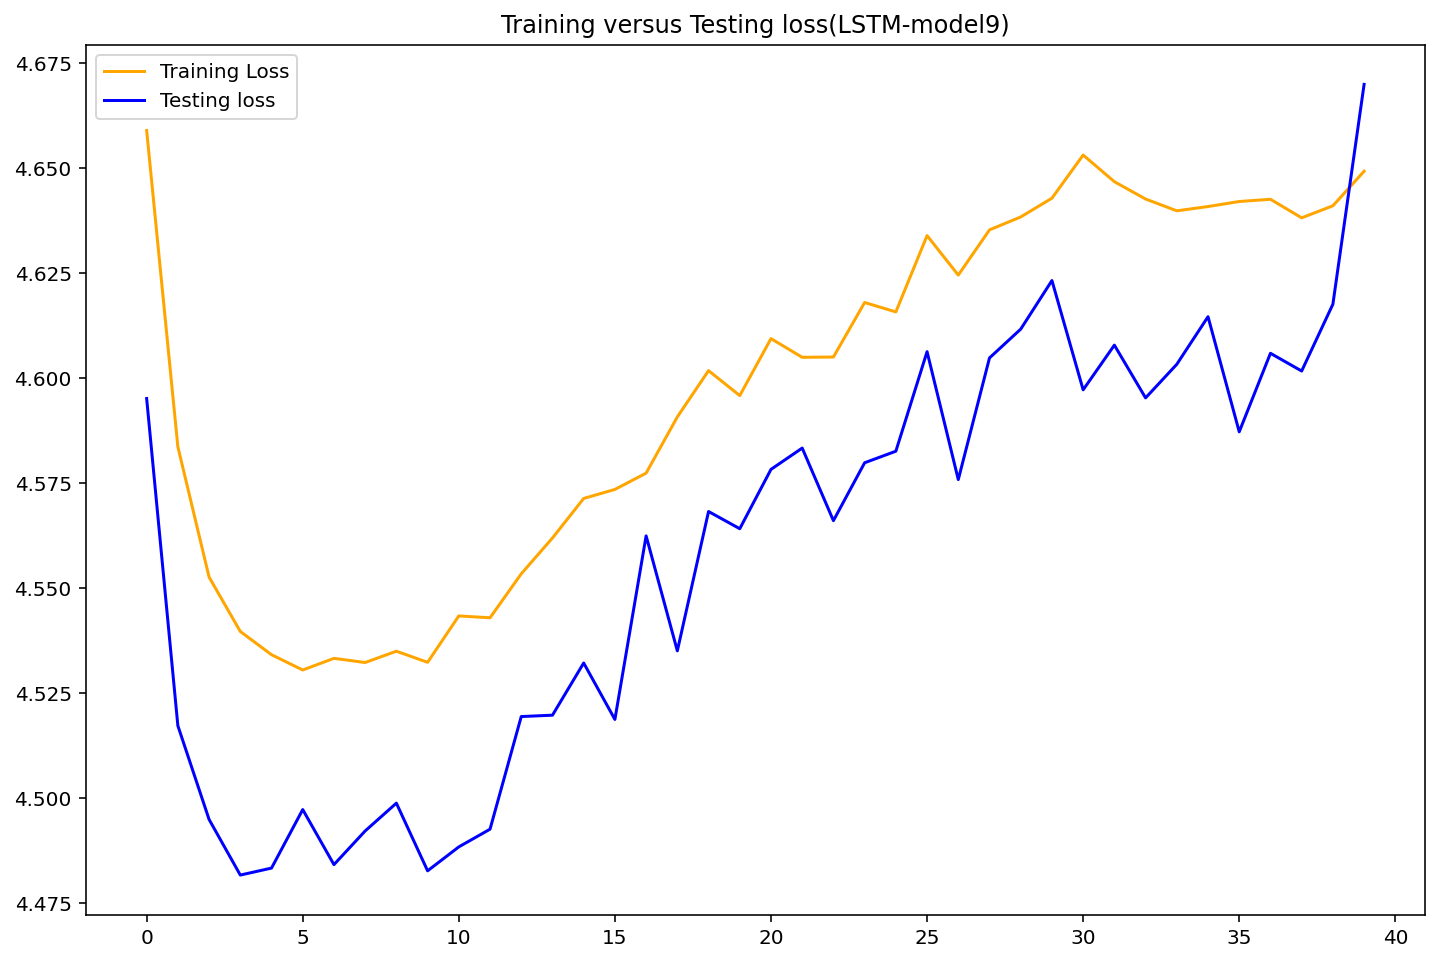

In [70]:
train_loss9=history9.history['loss']
test_loss9= history9.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(LSTM-model9)')
plt.plot(train_loss9, label ='Training Loss', color = 'orange')
plt.plot(test_loss9, label = 'Testing loss', color = 'blue')
plt.legend();
plt.savefig('9thmodel_loss_plot.png')

In [87]:
model10 = Sequential()
model10.add(LSTM(512, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model10.add(Dropout(0.05))
model10.add(LSTM(256, return_sequences = False))
model10.add(Dropout(0.05))
model10.add(Dense(512, activation='relu'))
model10.add(Dropout(0.05))
model10.add(Dense(256, activation='relu'))
model10.add(Dropout(0.05))
model10.add(Dense(128, activation='relu'))
model10.add(Dropout(0.05))
model10.add(Dense(len(unique_y), activation = 'softmax'))
model10.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=.005))
model10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32, 512)           1052672   
                                                                 
 dropout_10 (Dropout)        (None, 32, 512)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               131584    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)              

In [88]:
mc10=ModelCheckpoint('best_model_10.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history10=model10.fit(np.array(x_tr), np.array(y_tr), batch_size=32, 
                    epochs=40, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc10])

Epoch 1/40
11549/11549 [==============================] - ETA: 0s - loss: 4.7484
Epoch 00001: val_loss improved from inf to 4.73730, saving model to best_model_10.h5
11549/11549 [==============================] - 102s 9ms/step - loss: 4.7484 - val_loss: 4.7373
Epoch 2/40
11548/11549 [============================>.] - ETA: 0s - loss: 4.7402
Epoch 00002: val_loss did not improve from 4.73730
11549/11549 [==============================] - 94s 8ms/step - loss: 4.7402 - val_loss: 4.7373
Epoch 3/40
11549/11549 [==============================] - ETA: 0s - loss: 4.7376
Epoch 00003: val_loss improved from 4.73730 to 4.73606, saving model to best_model_10.h5
11549/11549 [==============================] - 94s 8ms/step - loss: 4.7376 - val_loss: 4.7361
Epoch 4/40
11545/11549 [============================>.] - ETA: 0s - loss: 4.7363
Epoch 00004: val_loss improved from 4.73606 to 4.73392, saving model to best_model_10.h5
11549/11549 [==============================] - 93s 8ms/step - loss: 4.7363 - va

In [89]:
model10= load_model('best_model_10.h5')

In [102]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions10 = []

for i in range(50):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model10.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions10.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions10)

[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]


In [99]:
predicted_notes10 = [x_int_to_note[i] for i in predictions10]
convert_to_midi(predicted_notes10)
predicted_notes10

['D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5',
 'D5']

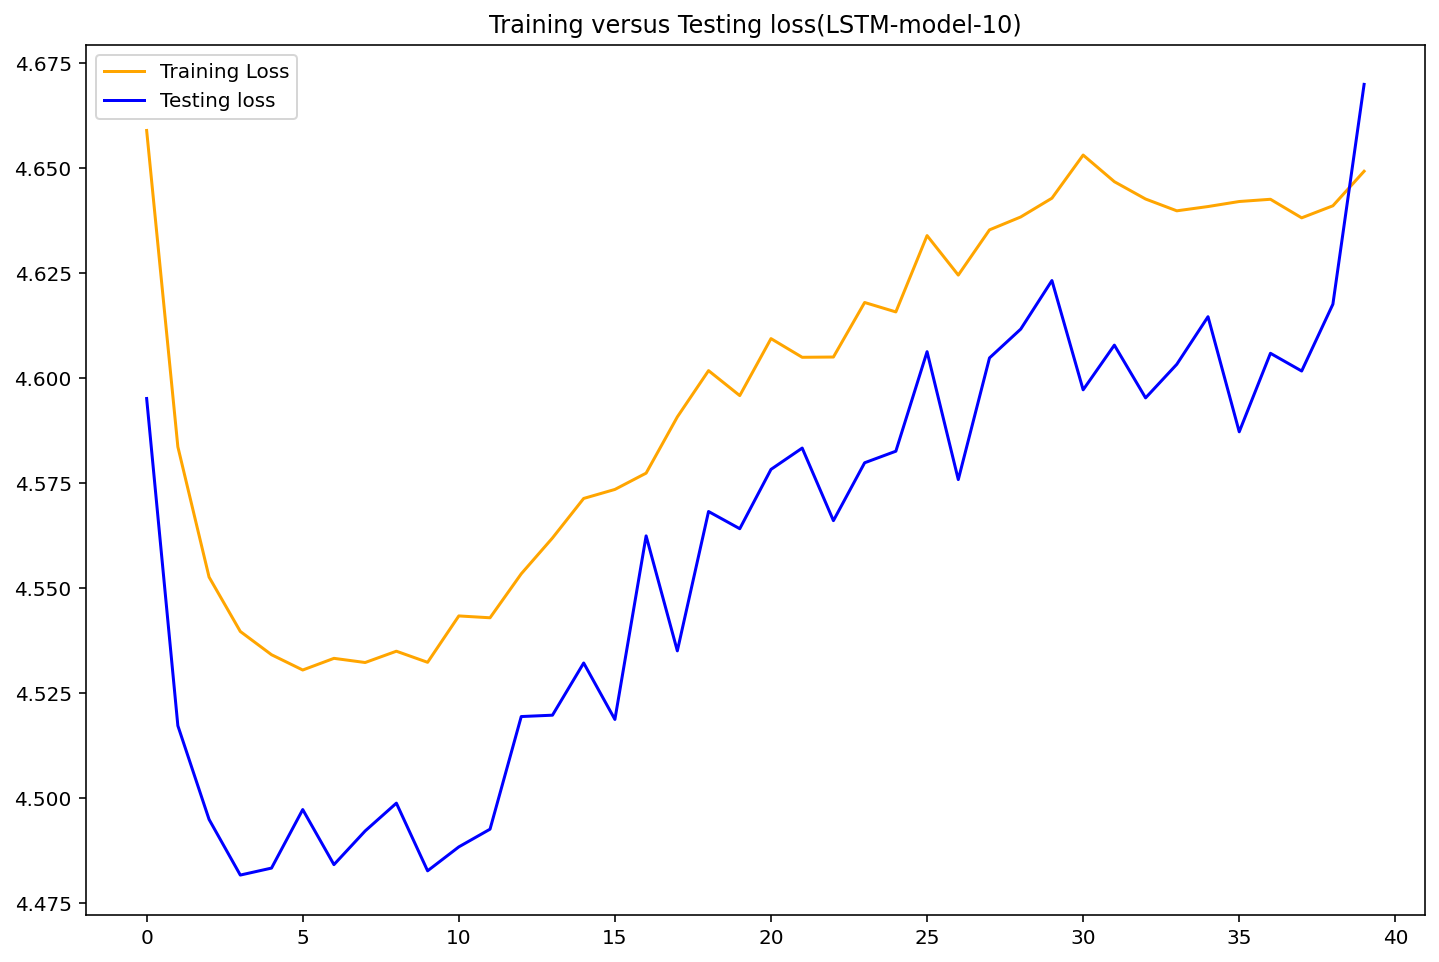

In [100]:
train_loss10=history10.history['loss']
test_loss10= history10.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(LSTM-model-10)')
plt.plot(train_loss9, label ='Training Loss', color = 'orange')
plt.plot(test_loss9, label = 'Testing loss', color = 'blue')
plt.legend();
plt.savefig('10thmodel_loss_plot.png')